In [89]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [90]:
#GPS Daten zur Kalbrierung der z-Koordinate
lake7 = 2208.9384 #20.08 08:40 UTC
lake8 = 2208.9486
lake9 = 2208.9602
lake789 = (lake7+lake8+lake9)/3
pressure789 = 0.874038696*100000

lake20 = 2208.6877 #23.08 10:26 UTC
pressure20 = 0.859085083*100000

upperstream2 = 2424.8743 #21.08 11:48 UTC
pressure2 = 0.812606812*100000
print(lake789)

2208.9490666666666


In [111]:
def pressure_to_level(df, P1, H1, P2=0, H2=0):
    
    # Lineare Umrechnung
    if P2 == 0 or H2 == 0:
        P_all = df['P1 [bar] - 205145-10mH2O'] * 1e5  # falls in bar, in Pa umrechnen
        H_all = H1 + (P_all - P1) * H1/P1
        
    else:
        P_all = df['P1 [bar] - '] * 1e5  # falls in bar, in Pa umrechnen
        H_all = H1 + (P_all - P1) * (H2 - H1) / (P2 - P1)
    
    # Ergebnis in DataFrame speichern
    df['Lake level [m.a.s.l.]'] = H_all

    return df

In [113]:
def plot_ctd(df_long, start, end, site):
    import matplotlib.pyplot as plt
    import pandas as pd

    # Zeitspalte in datetime umwandeln
    df_long['Datetime [local time]Europe/Berlin'] = pd.to_datetime(df_long['Datetime [local time]Europe/Berlin'])

    # Filter für Zeitraum
    df = df_long[(df_long['Datetime [local time]Europe/Berlin'] >= start) & 
                 (df_long['Datetime [local time]Europe/Berlin'] <= end)]

    # Plot mit zwei y-Achsen
    fig, ax1 = plt.subplots(figsize=(10,6))

    # Linke Achse: Seespiegel
    ax1.plot(df['Datetime [local time]Europe/Berlin'], 
             df['Lake level [m.a.s.l.]'], 
             color='blue', 
             label='Lake level [m.a.s.l.]',
             linewidth=0.8)
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Water level [m.a.s.l.]', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')
    ax1.grid(True)
    
    # Linke Achse zusätzlich: Abfluss
    # Lake level
    lake_level = df['Lake level [m.a.s.l.]']
    # Abfluss skalieren (linear auf den Bereich vom Seespiegel)
    discharge = gletsch['Discharge']
    discharge_scaled = ((discharge - discharge.min()) / (discharge.max() - discharge.min())) \
                   * (lake_level.max() - lake_level.min()) + lake_level.min()
    ax1.plot(gletsch['Datetime'], 
             discharge_scaled, 
             color='green', label='Discharge Gletsch [m³/s]', linewidth=0.8, linestyle='--')

    lines_1, labels_1 = ax1.get_legend_handles_labels()
    
    # Rechte Achse: Temperatur
    if site == 'lake':
        ax2 = ax1.twinx()
        ax2.plot(df['Datetime [local time]Europe/Berlin'], 
                 df['TOB1 [°C] - '], 
                 color='red', 
                 label='TOB1 [°C]',
                 linewidth=0.8)
        ax2.set_ylabel('Temperature [°C]', color='red')
        ax2.tick_params(axis='y', labelcolor='red')

        lines_2, labels_2 = ax2.get_legend_handles_labels()
        # Legende kombinieren
        ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left')

    else:
        ax1.legend(lines_1, labels_1, loc='upper left')

    plt.title(f'Pressure and temperature evolution at {site}')
    fig.tight_layout()
    plt.show()

Index(['No', 'Datetime [local time]Europe/Berlin', 'Datetime [UTC]',
       'P1 [bar] - 205145-10mH2O', 'TOB1 [°C] - 205145-10mH2O',
       'Conductivity raw [mS/cm] - 205145-10mH2O'],
      dtype='object')
Index(['No', 'Datetime [local time]Europe/Berlin', 'Datetime [UTC]',
       'P1 [bar] - ', 'TOB1 [°C] - ', 'Lake level [m.a.s.l.]'],
      dtype='object')
Index(['No', 'Datetime [local time]Europe/Berlin', 'Datetime [UTC]',
       'P1 [bar] - 205145-10mH2O', 'TOB1 [°C] - 205145-10mH2O',
       'Conductivity raw [mS/cm] - 205145-10mH2O', 'Lake level [m.a.s.l.]'],
      dtype='object')


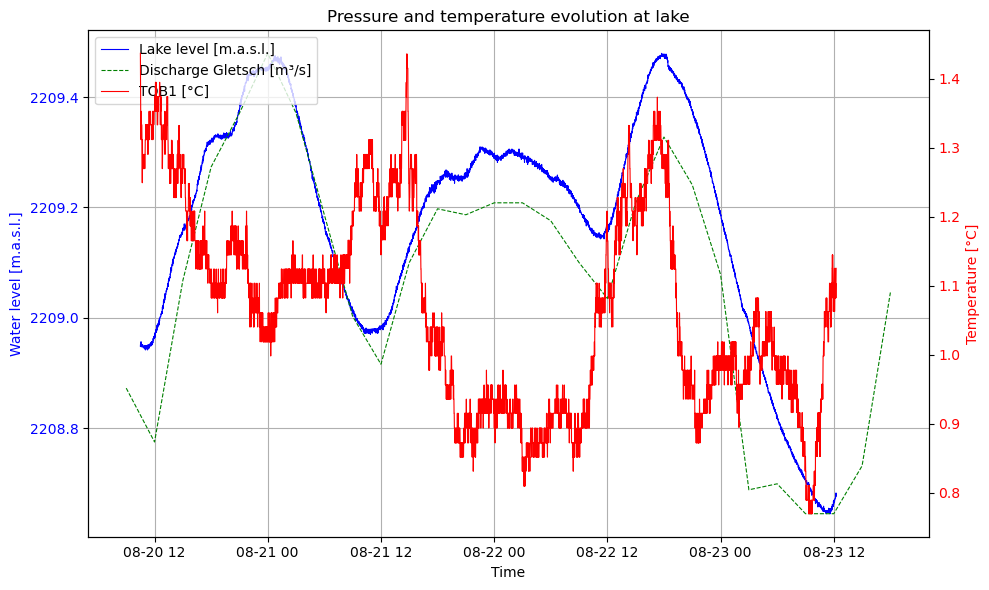

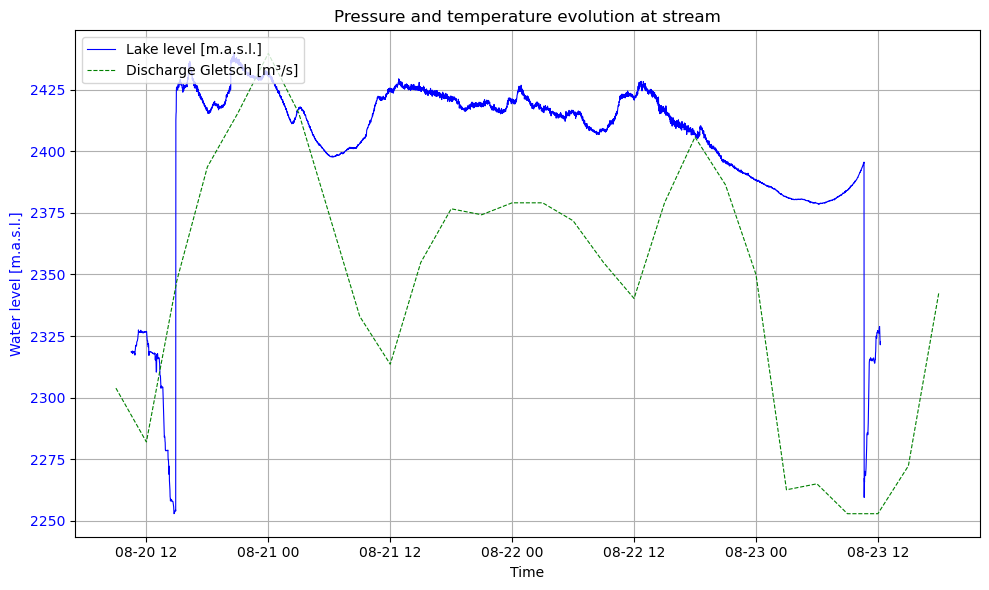

In [119]:
df_lake = pd.read_csv("Drucksensor_SeeUnten.csv", sep=";")
start_lake = '2025-08-20 10:30'
end_lake = '2025-08-23 12:15'

df_stream = pd.read_csv("Drucksensor_stream.csv", sep=";")
print(df_stream.columns)

pressure_to_level(df_lake, pressure789, lake789, pressure20, lake20)
pressure_to_level(df_stream, pressure2, upperstream2)
print(df_lake.columns)
print(df_stream.columns)

plot_ctd(df_lake, start_lake, end_lake, site = "lake")
plot_ctd(df_stream, start_lake, end_lake, site = "stream")

Index(['Datum & Zeit', 'Abfluss (m³/s)', 'Pegel (müM)'], dtype='object')


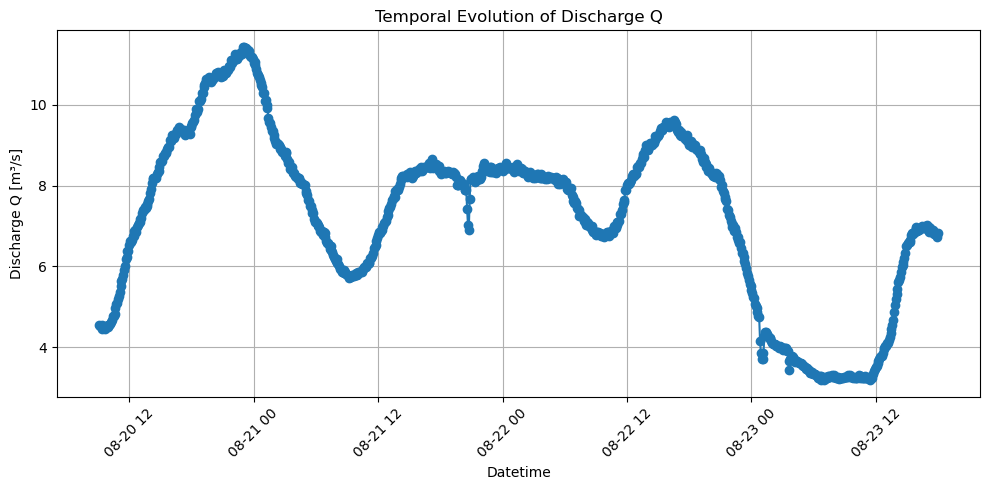

In [130]:
### IMPORT DISCHARGE DATA FROM GLETSCH ###
# Datei einlesen
gletsch = pd.read_csv('../rhone_5min.csv', sep=',')

# zuschneiden
gletsch = gletsch.iloc[5601:6573]
print(gletsch.columns)

# Spalte 'Q' sauber benennen
gletsch.rename(columns={'Abfluss (m³/s)': 'Discharge'}, inplace=True)
gletsch.rename(columns={'Datum & Zeit': 'Datetime'}, inplace=True)

# Datum und Zeit zu einer neuen Spalte kombinieren
gletsch['Datetime'] = pd.to_datetime(gletsch['Datetime'])

# Plot
plt.figure(figsize=(10, 5))
plt.plot(gletsch['Datetime'], gletsch['Discharge'], marker='o', linestyle='-')
plt.xlabel('Datetime')
plt.ylabel('Discharge Q [m³/s]')
plt.title('Temporal Evolution of Discharge Q')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()